In [1]:
import requests
import sys
sys.path.append('/home/greg/GitHub/')
import pyEDIutils.changes as edi
import pandas as pd
import numpy as np

## Archive a request for earlier data

Do this if needed to update the request archives for the current report .

In [ ]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2020-01-28&scope=knb-lter-jrn"
# This is from the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
# Only do this if it isn't archived yet!
edi.archive_requested_changes('2023-06-02', '2023-07-15')

## Load archived requests and most recent data

In [2]:
archived = edi.load_archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
Reading archived PASTA request knb-lter-jrn_20201202-20210601.xml
Reading archived PASTA request knb-lter-jrn_20210602-20220101.xml
Reading archived PASTA request knb-lter-jrn_20220102-20220531.xml
Reading archived PASTA request knb-lter-jrn_20220601-20221101.xml
Reading archived PASTA request knb-lter-jrn_20221102-20230315.xml
Reading archived PASTA request knb-lter-jrn_20230316-20230601.xml
Reading archived PASTA request knb-lter-jrn_20230602-20230715.xml
9 duplicate records were removed.


In [3]:
# Find the last PASTA entry in the archive and convert to datetime
last_archived = pd.to_datetime(archived.date.iloc[-1])

In [4]:
# If the last_archived  value is less than report endtime, get the most recent
# changes (default is retrieve to today) and concatenate to archived requests
if last_archived < pd.to_datetime('today'):
    last_archived_plus1d = last_archived.date() + pd.DateOffset(1)
    # Request changes from last archive to enddate
    new = edi.request_changes(last_archived_plus1d.isoformat())
    # Concat
    df = pd.concat([archived, new])
else:
    df = archived.copy()
    

Requesting PASTA changes for knb-lter-jrn from 2023-07-09T00:00:00 to None
https://pasta.lternet.edu/package/changes/eml?fromDate=2023-07-09T00%3A00%3A00&toDate=2023-08-11&scope=knb-lter-jrn
0 duplicate records were removed.


In [5]:
df.tail()

,date,pkgid,action
98,2023-07-20T22:47:59.52,210548048,updateDataPackage
99,2023-07-20T22:53:04.55,210548020,updateDataPackage
100,2023-07-20T22:57:31.048,210548037,updateDataPackage
101,2023-07-28T23:13:17.124,210527001,createDataPackage
102,2023-08-01T20:40:41.323,210011004,updateDataPackage


In [8]:
# Add method count columns
df = edi.get_counts(df)
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
0,2015-04-17T14:42:05.936,2100011003,createDataPackage,0,1,0,1,011
1,2015-04-17T15:43:26.172,210120002,createDataPackage,0,1,0,1,120
2,2015-04-17T15:43:26.771,2100392001,createDataPackage,0,1,0,1,392
3,2015-04-17T15:43:41.508,2100169002,createDataPackage,0,1,0,1,169
4,2015-04-17T15:43:45.55,2100010001,createDataPackage,0,1,0,1,010


In [9]:
# Count deleted packages
deleted_pkgs = df.loc[df.action=='deleteDataPackage','pkgid']
print(deleted_pkgs)

223    2100001002
224    2100002001
225    2100007001
227    2100010001
228    2100011001
229    2100011003
230    2100011004
232    2100011005
233    2100086001
234    2100086002
235    2100086003
236    2100086004
237    2100086005
238    2100086006
239    2100086007
240    2100086008
241    2100086009
242    2100119001
243    2100121004
244    2100121005
245    2100126001
246    2100126003
247    2100127001
249    2100169001
250    2100169002
251    2100278001
252    2100278002
254    2100287001
255    2100288001
257    2100351001
260    2100365001
261    2100379001
262    2100379002
263    2100379003
264    2100380001
265    2100392001
266    2100409001
267    2100409002
276     210038001
277     210338007
278     210338008
281     210169001
283     210169002
12       21038001
456     210860002
Name: pkgid, dtype: int64


## Create daily data file

In [10]:
# Sum to daily methods
daily = edi.counts_to_daily(df)
daily.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


## Plot activity since 2013


In [11]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
#font = {'family' : 'normal',
#        'weight' : 'normal',
#        'size'   : 14}

#matplotlib.rc('font', **font)

In [12]:
# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

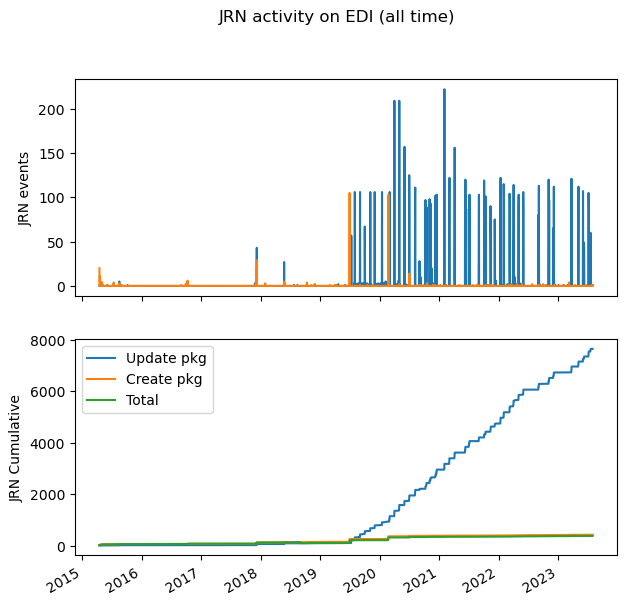

In [13]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily.index, daily.n_create.cumsum(), label='Create pkg')
ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (all time)')
plt.legend()

import os
#fig.savefig(os.path.expanduser("~/data/GD_gmaurer@nmsu/IM/figures/JRN_EDI_all_{0}.png".format(now)),
#            dpi=150)

### Total number of packages

In [14]:
daily.n_tot.sum()

375

### Total number of non-met packages

NPP met = 437, CSIS met = 548

In [15]:
df.index = pd.to_datetime(df.date)
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
df.loc[nomet,['n_update', 'n_create', 'n_tot']].resample('D').sum().n_tot.sum()


152

### All changes excluding met

In [16]:
daily_nomet = edi.counts_to_daily(df.loc[nomet,:])
daily_nomet.head()
daily_nomet.tail()

,n_update,n_create,n_tot
date,,,
2023-07-28,0,1,1
2023-07-29,0,0,0
2023-07-30,0,0,0
2023-07-31,0,0,0
2023-08-01,1,0,0


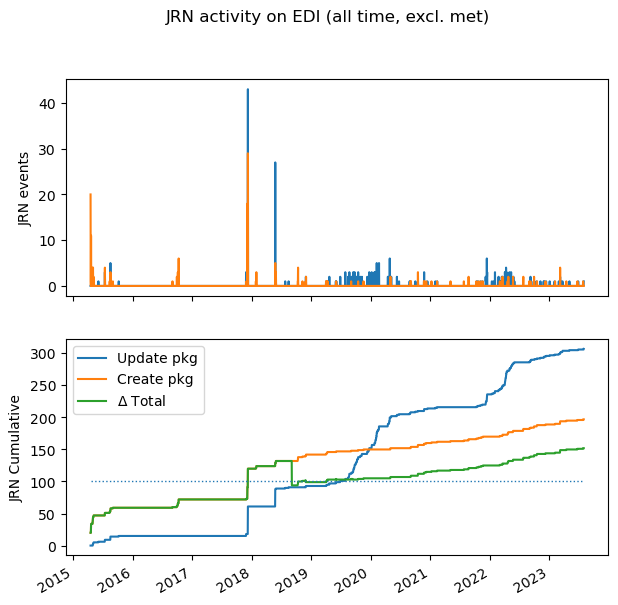

In [17]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].hlines(y=100, xmin=daily_nomet.index.min(), xmax=daily_nomet.index.max(), ls=':', lw=1)

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (all time, excl. met)')
plt.legend()

## Plot activity since Sept2018 (excluding Met)

In [18]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
startdt = "2018-09-05"
daily_r_nomet = edi.counts_to_daily(df.loc[np.logical_and(nomet, df.index > startdt),:])
daily_r_nomet.head()

,n_update,n_create,n_tot
date,,,
2018-10-10,0,1,1
2018-10-11,0,1,1
2018-10-12,0,4,4
2018-10-13,0,0,0
2018-10-14,0,0,0


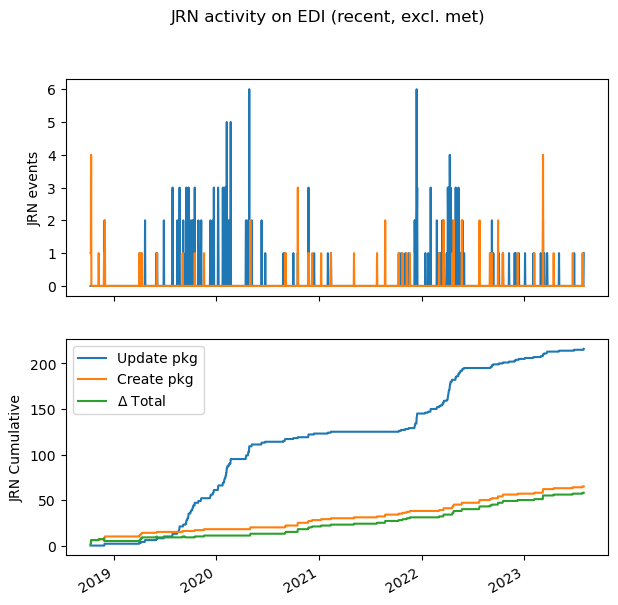

In [20]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_r_nomet.index, daily_r_nomet.n_update, label='Update pkg')
ax[0].plot(daily_r_nomet.index, daily_r_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_r_nomet.index, daily_r_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_r_nomet.index, daily_r_nomet.n_create.cumsum(), label='Create pkg')
ax[1].plot(daily_r_nomet.index, daily_r_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (recent, excl. met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "~/data/GD_gmaurer@nmsu/IM/figures/JRN_EDI_recNoMet_{0}.png".format(now)),
            dpi=150)

## Summary since Sept 2018 (after LTER7 probation)

In [19]:
# Monthly progress
monthly_r_nomet = daily_r_nomet.resample('M').sum()
monthly_r_nomet

,n_update,n_create,n_tot
date,,,
2019-04-30,4,4,4
2019-05-31,0,0,0
2019-06-30,4,1,0
2019-07-31,3,0,0
2019-08-31,8,0,0
2019-09-30,15,1,0
2019-10-31,13,1,1
2019-11-30,3,1,1
2019-12-31,9,0,0


In [ ]:
# Unique packages updated (excluding met)
recent = df.loc[df.index > startdt,]
recent_nomet = np.logical_and(recent.studyid!='437', recent.studyid!='548')
uniqueUp = recent.loc[np.logical_and(recent_nomet, recent.action=='updateDataPackage'),].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp

array([210351003, 210328003, 210328001, 210120001, 210127001, 210380001,
       210288001, 210351001, 210351002, 210461001, 210086003, 210086008,
       210002001, 210086009, 210086005, 210086004, 210086007, 210308004,
       210228001, 210120002, 210013001, 210086002, 210086001, 210121005,
       210121008, 210407001, 210086006, 210119001, 210011005, 210001002,
       210011002, 210011003, 210011004, 210013002, 210013003, 210412001,
       210012001, 210012002, 210010001, 210122001, 210328002, 210308001,
       210308002, 210308003, 210308005, 210126003, 210262001, 210262004,
       210262005, 210128001, 210128002, 210262008, 210392001, 210379001,
       210379002, 210379003, 210287001, 210278002, 210278001, 210338006,
       210338004, 210338002, 210425001, 210262010, 210365001, 210385001,
       210385004, 210385005, 210385006, 210385008, 210385002, 210385003,
       210385007,       100, 210001001, 210394009, 210395001, 210409002,
       210008001, 210007001, 210008002, 210015001, 

In [ ]:
# Unique updates since last meeting
last_meeting = '2021-01-01'

vrecent = df.loc[df.index >= last_meeting]
vrecent_nomet = np.logical_and(vrecent.studyid!='437', vrecent.studyid!='548')
uR = vrecent.loc[np.logical_and(vrecent_nomet, vrecent.action=='updateDataPackage'),].pkgid.unique()
# Unique updates before last meeting (to startdt)
oEDI = df.loc[np.logical_and(df.index > startdt, df.index < last_meeting),]
uO = oEDI.loc[np.logical_and(oEDI.studyid!='437', oEDI.action=='updateDataPackage'),].pkgid.unique()
print(uR)
print(uO)

[210380001 210351004 210126001 200021001 210015002 210015003 210015001
 210121001 210368001 210368002 210368003 210368004 210121006 210370001
 210370002 210301001 210301002 210409001 210389001 210389002 210011004
 210011002 200045001 210408005 210398001 210398002]
[210351003 210328003 210328001 210120001 210127001 210380001 210288001
 210351001 210351002 210461001 210086003 210086008 210002001 210086009
 210086005 210086004 210086007 210308004 210228001 210120002 210013001
 210086002 210086001 210121005 210121008 210407001 210086006 210119001
 210011005 210001002 210011002 210011003 210011004 210013002 210013003
 210412001 210012001 210012002 210010001 210122001 210328002 210308001
 210308002 210308003 210308005 210126003 210262001 210262004 210262005
 210128001 210128002 210262008 210392001 210379001 210379002 210379003
 210287001 210278002 210278001 210338006 210338004 210338002 210425001
 210262010 210365001 210548016 210548031 210548076 210548046 210548025
 210548061 210548001 2105

In [29]:
uR[~np.in1d(uR, uO)]

array([210351004, 210126001, 200021001, 210015002, 210015003, 210121001,
       210368001, 210368002, 210368003, 210368004, 210121006, 210370001,
       210370002, 210301001, 210301002, 210409001])

In [26]:
# Unique packages deleted
uniqueDel = recent.loc[np.logical_and(recent_nomet, recent.action=='deleteDataPackage'),].pkgid.unique()
uniqueDel

array([210038001, 210338007, 210338008, 210169001, 210169002,  21038001,
       210860002])

In [27]:
# Unique packages created (See above)
uniqueCreate = recent.loc[np.logical_and(recent_nomet, recent.action=='createDataPackage'),].pkgid.unique()
uniqueCreate

array([210520001, 210327001, 210338005, 210338006, 210338007, 210338008,
       210472001, 210380001, 210128001, 210128002, 210351003, 210328003,
       210328001, 210328002,  21038001, 210860002, 210011001,       100,
       210420001, 210420002, 210394008, 210386002, 210008002, 210386009,
       210386008, 210386011, 210493001, 210313001, 210408005, 210351004,
       210228002,       101, 210389001, 210389002, 200021001, 200022001,
       210500001, 210469001])